In [11]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import bean as be
from bean.preprocessing.data_class import TilingSortingReporterScreenData
import matplotlib

In [2]:
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["axes.unicode_minus"] = False

In [3]:
plt.style.use('default')


In [8]:
bdata_path = "../../../results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_annotated_spacer0.1_0.3.h5ad"

In [9]:
bdata = be.read_h5ad(bdata_path)

In [13]:
bdata

Genome Editing Screen comprised of n_guides x n_conditions = 7500 x 25
   guides:    'Region', 'pos', 'strand', 'sequence', 'Reporter', 'barcode', '5-nt PAM', 'genomic_pos', 'pos_seq', 'guide_len', 'start_pos', 'target_start', 'masked_sequence', 'masked_barcode', 'Group', 'edit_rate', 'target_allEdited', 'severity', 'group_allEdited', 'target_behive', 'group_behive', 'chr'
   samples:   'rep', 'bin', 'gini_X', 'median_corr_X', 'median_lfc_corr.top_bot', 'median_editing_rate', 'mask', 'lower_quantile', 'upper_quantile', 'size_factor', 'bin_id', 'rep_id'
   samples_m: 
   samples_p: 
   layers:    'X_RPM', 'X_bcmatch', 'edit_rate', 'edits', 'lognorm_counts'
   uns:       'allele_counts', 'edit_counts', 'lfc', 'lfc_corr', 'metadata', 'repguide_mask', 'sig_allele_counts', 'sig_allele_counts_spacer', 'sig_allele_counts_spacer_0_19', 'sig_allele_counts_spacer_0_19_A.G', 'sig_allele_counts_spacer_0_19_A.G_translated', 'sig_allele_counts_spacer_0_19_A.G_translated_prop0.1_0.3', 'target_base_ch

In [14]:
ndata_fullsort = TilingSortingReporterScreenData(
    bdata, allele_df_key = "sig_allele_counts_spacer_0_19_A.G_translated_prop0.1_0.3")

Linear fit of log(a0) ~ log(q): [b0, b1]=[-1.42324842  0.91435088], cov=[[ 0.00641774 -0.00095514]
 [-0.00095514  0.00014447]]
Linear fit of log(pi_a0) ~ log(q): [b0, b1]=[0.30265064 1.03324223], cov=[[ 3.53249952e-04 -7.34964018e-05]
 [-7.34964018e-05  1.57267949e-05]]


In [15]:
8*4*3455

110560

In [16]:
def get_q(X, sample_size_factors, sample_mask):
    """
    Obtain depth-normalized sample mean
    """
    n_reps, n_condits, n_guides = X.shape
    q_condit_guide = ((X/sample_size_factors[:,:,None])*sample_mask[:,:,None]).sum(axis=0)/sample_mask.sum(axis=0)[:,None]
    assert q_condit_guide.shape == (n_condits, n_guides)
    return(q_condit_guide)

def get_w(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample variance
    """
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    q = get_q(X, sample_size_factors, sample_mask)
    se = (X/sample_size_factors[:,:,None] - q)**2
    w=(se * sample_mask[:,:,None]).sum(axis=0)/(sample_mask.sum(axis=0))[:,None]
    return(w)

def get_w_c(X, sample_size_factors):
    n_reps, n_condits, n_guides = data.X.shape
    q = get_q(X+1, sample_size_factors)
    residual=(X+1)/sample_size_factors[:,:,None] - q[None,:,:] #(n_reps, n_condits, n_guides)
    covs = torch.zeros((n_condits, n_condits, n_guides))
    for i in range(n_reps):
        for j in range(n_guides):
            covs[:,:,j] += torch.outer(residual[i, :, j].T, residual[i, :, j])
    cov = (1/(n_reps-1))*covs
    return(cov)

def get_z(X, sample_size_factors, sample_mask):
    n_reps, n_condits, n_guides = data.X.shape
    q = get_q(X+1, sample_size_factors, sample_mask)
    z = q/n_reps * (1/sample_size_factors).sum(axis=0)[:,None]
    return(z)

In [17]:
data = ndata_fullsort
w = get_w(data.X, data.size_factor)
z = get_z(data.X, data.size_factor, data.sample_mask)
q = get_q(data.X, data.size_factor, data.sample_mask)

In [18]:
X = data.X
sample_size_factors = data.size_factor

n_reps, n_condits, n_guides = data.X.shape
q = get_q(X, sample_size_factors, data.sample_mask)
n = q.sum(axis=0)
p = q/n[None,:]

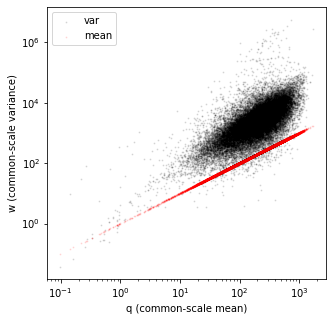

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var')
ax.scatter(q, q, s = 1, alpha = 0.1, c = 'red', label='mean')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("q (common-scale mean)")
ax.set_ylabel('w (common-scale variance)')

ax.legend()

In [20]:
multinom_var = n[None,:]*p*(1-p)
r = (w-q)/multinom_var
od = r-1
a0 = ((n-1)/(r - 1 + 1/(1-p)) -1).mean(axis=0)

In [21]:
"""
Returns fitted alpha 0 (sum of concentration) of Dirichlet-Multinomial
For the notation, see DESeq paper
"""

def get_valid_idx(x:torch.Tensor, y:torch.Tensor):
    return ~(torch.isnan(x) | torch.isnan(y) | torch.isinf(x) | torch.isinf(y))

def get_valid_vals(x, y):
    valid = get_valid_idx(x, y)
    return(x[valid].detach().numpy(), y[valid].detach().numpy())


def get_q(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample mean
    """
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    n_reps, n_condits, n_guides = X.shape
    q_condit_guide = ((X/sample_size_factors[:,:,None])*sample_mask[:,:,None]).sum(axis=0)/sample_mask.sum(axis=0)[:,None]
    assert q_condit_guide.shape == (n_condits, n_guides)
    return(q_condit_guide)

def get_w(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample variance
    """
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    q = get_q(X+1, sample_size_factors, sample_mask)
    se = ((X+1)/sample_size_factors[:,:,None] - q)**2
    w=(se * sample_mask[:,:,None]).sum(axis=0)/(sample_mask.sum(axis=0))[:,None]
    return(w)

def linear(x, b0, b1):
    return b0 + b1*x

def get_fitted_alpha0(X, sample_size_factors, sample_mask = None):
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    w = get_w(X+1, sample_size_factors, sample_mask = sample_mask)
    q = get_q(X+1, sample_size_factors, sample_mask = sample_mask)
    n = q.sum(axis=0)   # depth-normalized total counts across bins
    p = q/n[None,:]     # depth-normalized p for Multinomial
    multinom_var = n[None,:]*p*(1-p)    # theoretical Multinomial variance
    r = (w-q)/multinom_var
    a0 = (n/(r - 1 + 1/(1-p))).mean(axis=0)

    x, y = get_valid_vals(n.log(), a0.log())
    popt, pcov = curve_fit(linear, x, y)
    print("Linear fit of log(a0) ~ log(q): [b0, b1]={}, cov={}".format(popt, pcov))
    a0_est = np.exp(linear(q.sum(axis=0).log().numpy(), *popt))
    return(a0_est)

In [22]:
get_fitted_alpha0(ndata_fullsort.X, ndata_fullsort.size_factor, ndata_fullsort.sample_mask)

Linear fit of log(a0) ~ log(q): [b0, b1]=[-1.24131214  0.88950749], cov=[[ 0.00611268 -0.00090982]
 [-0.00090982  0.00013764]]


array([ 75.42478 , 101.56911 , 101.11063 , ...,  91.353424, 163.15222 ,
        28.656084], dtype=float32)

In [23]:
X=data.X
sample_size_factors=data.size_factor
sample_mask = data.sample_mask

w = get_w(X, sample_size_factors, sample_mask = sample_mask)
q = get_q(X, sample_size_factors, sample_mask = sample_mask)
n = q.sum(axis=0)   # depth-normalized total counts across bins
p = q/n[None,:]     # depth-normalized p for Multinomial
multinom_var = n[None,:]*p*(1-p)    # theoretical Multinomial variance
r = w/multinom_var
a0 = ((n-1)/(r - 1 + 1/(1-p))-1).mean(axis=0)

x, y = get_valid_vals(n.log(), a0.log())

In [24]:
def linear(x, b0, b1):
    return b0 + b1*x

In [25]:
def get_valid_idx(x, y):
    return ~(torch.isnan(x) | torch.isnan(y) | torch.isinf(x) | torch.isinf(y))

def get_valid_vals(x, y):
    valid = get_valid_idx(x, y)
    return(x[valid].detach().numpy(), y[valid].detach().numpy())

In [26]:
popt, pcov = curve_fit(linear, x, y)

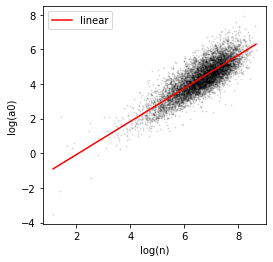

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(x, y, s = 1, alpha = 0.1, c = 'black')
plt.plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
plt.xlabel("log(n)")
plt.ylabel("log(a0)")
plt.legend()

In [28]:
plt.style.use('jr')

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


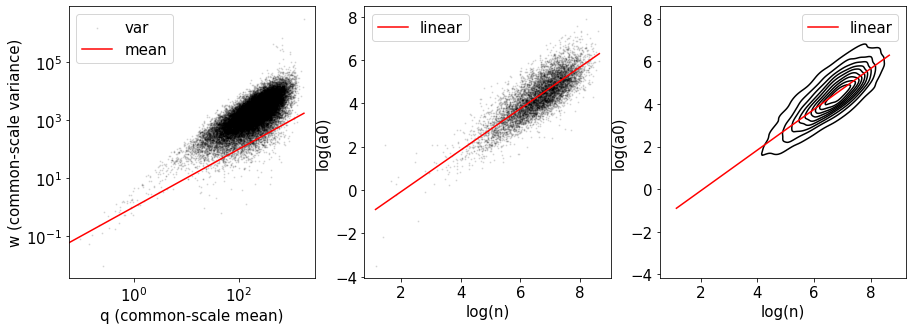

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var', rasterized=True)
ax[0].plot(np.sort(q.flatten()), np.sort(q.flatten()), c = 'red', label='mean')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("q (common-scale mean)")
ax[0].set_ylabel('w (common-scale variance)')
ax[0].legend()

ax[1].scatter(x, y, s = 1, alpha = 0.1, c = 'black', rasterized=True)
ax[1].plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
ax[1].set_xlabel("log(n)")
ax[1].set_ylabel("log(a0)")
ax[1].legend()

sns.kdeplot(x=x, y=y, c='black', ax = ax[2])
ax[2].plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
ax[2].set_xlabel("log(n)")
ax[2].set_ylabel("log(a0)")
ax[2].legend()

fig.savefig("cds_sorting_bins.pdf")

## Allele alpha


How about the a0 in pi ~ Dir(<pi_0, pi_1>*a0)?

In [31]:
import bean.preprocessing.get_pi_alpha0 as pa
q = pa.get_q(data.allele_counts_control+1, data.size_factor_control, )
w = pa.get_w(data.allele_counts_control+1, data.size_factor_control, )

In [32]:
q.shape

torch.Size([7500, 7])

In [33]:
n.shape

torch.Size([7500])

In [34]:
n = q.sum(-1)
p = q / q.sum(axis=-1)[:, None]
r = (w - q) / (n[:, None] * p * (1 - p))
a0 = torch.nanmean(((n[:, None] - 1) / (r - 1 + 1 / (1 - p)) - 1), axis=-1)

In [35]:
a0.shape

torch.Size([7500])

WARNING @ Sun, 20 Aug 2023 00:04:52:
	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument. 



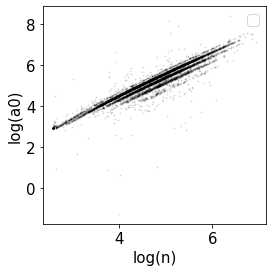

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(n.log(), a0.log(), s = 1, alpha = 0.1, c = 'black')
#plt.plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
plt.xlabel("log(n)")
plt.ylabel("log(a0)")
plt.legend()
#plt.savefig("linear_trend.pdf")

In [37]:
x, y = get_valid_vals(n.log(), a0.log())
popt_allele, pcov = curve_fit(linear, x, y)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's', 'c'
  cset = contour_func(


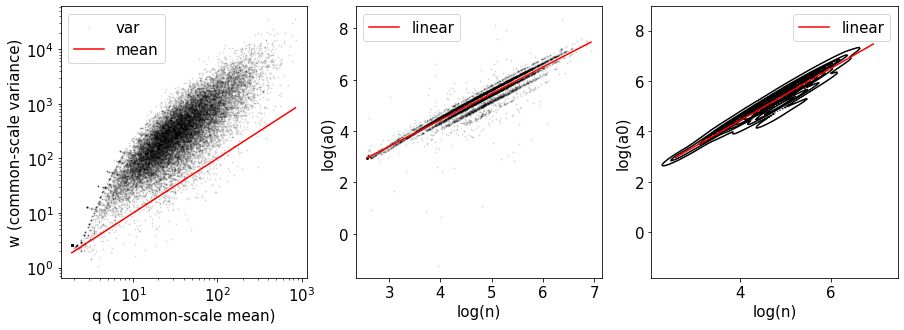

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var', rasterized=True)
ax[0].plot(np.sort(q.flatten()), np.sort(q.flatten()), c = 'red', label='mean')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("q (common-scale mean)")
ax[0].set_ylabel('w (common-scale variance)')
ax[0].legend()

ax[1].scatter(x, y, s = 1, alpha = 0.1, c = 'black', rasterized=True)
ax[1].plot(np.sort(x), linear(np.sort(x), *popt_allele), c = 'red', label='linear')
ax[1].set_xlabel("log(n)")
ax[1].set_ylabel("log(a0)")
ax[1].legend()

sns.kdeplot(x=x, y=y, s = 1, c='black', ax = ax[2])
ax[2].plot(np.sort(x), linear(np.sort(x), *popt_allele), c = 'red', label='linear')
ax[2].set_xlabel("log(n)")
ax[2].set_ylabel("log(a0)")
ax[2].legend()

fig.savefig("cds_alleles.pdf")